<a href="https://colab.research.google.com/github/michalinahulak/kickstarter_project/blob/main/kickstarter_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


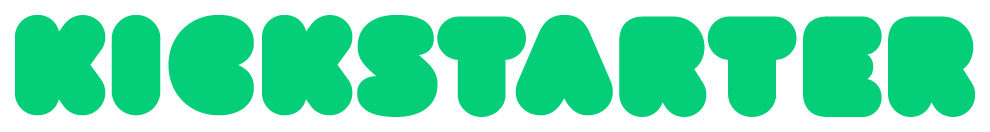
# Introduction

Project carried out as a part of learning and exercises during the Data Science course. Includes classification issues.

The kickstarter platform was founded in 2009. It is an English-language crowdfunding site where fundraisers are conducted for various projects (musical, artistic, etc.).

The imported data includes columns with information about collections, including name of the fundraiser, start and end date, set fundraiser goal, category, number of supporters and country.

# The purpose of the project

The aim of the project is to build a model that determines the success of the fundraiser based on data that can be obtained even before the start of the fundraising. From a business point of view, it is useful to determine whether we are successful or not before starting the fundraiser.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls -la '/content/drive/My Drive/Colab Notebooks/kickstarter projekt'

In [4]:
%cd /content/drive/My Drive/Colab Notebooks/kickstarter projekt

/content/drive/My Drive/Colab Notebooks/kickstarter projekt


# Imports

In [ ]:
pip install ydata-profiling

In [ ]:
!pip install catboost

In [ ]:
!pip install Optuna

In [7]:
import pandas as pd
import numpy as np
import random

import gdown

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import joblib
import sklearn
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from ydata_profiling import ProfileReport

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

# Functions

In [10]:
def calculate_metrics(truth_train, predicted_train, truth_val, predicted_val, truth_test, predicted_test, average='weighted'):
    accuracy_train = round(accuracy_score(truth_train, predicted_train), 2)
    precision_train = round(precision_score(truth_train, predicted_train, average=average), 2)
    recall_train = round(recall_score(truth_train, predicted_train, average=average), 2)
    fscore_train = round(f1_score(truth_train, predicted_train, average=average), 2)

    total_train = len(truth_train)
    mislabeled_train = (truth_train != predicted_train).sum()

    accuracy_val = round(accuracy_score(truth_val, predicted_val), 2)
    precision_val = round(precision_score(truth_val, predicted_val, average=average), 2)
    recall_val = round(recall_score(truth_val, predicted_val, average=average), 2)
    fscore_val = round(f1_score(truth_val, predicted_val, average=average), 2)

    total_val = len(truth_val)
    mislabeled_val = (truth_val != predicted_val).sum()

    accuracy_test = round(accuracy_score(truth_test, predicted_test), 2)
    precision_test = round(precision_score(truth_test, predicted_test, average=average), 2)
    recall_test = round(recall_score(truth_test, predicted_test, average=average), 2)
    fscore_test = round(f1_score(truth_test, predicted_test, average=average), 2)

    total_test = len(truth_test)
    mislabeled_test = (truth_test != predicted_test).sum()

    metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Total', 'Mislabeled'],
        'Value_train': [accuracy_train, precision_train, recall_train, fscore_train, total_train, mislabeled_train],
        'Value_val': [accuracy_val, precision_val, recall_val, fscore_val, total_val, mislabeled_val],
        'Value_test': [accuracy_test, precision_test, recall_test, fscore_test, total_test, mislabeled_test]
    })

    return metrics

In [11]:
def model_pipeline(dataset, model):
    dataset = dataset.drop(['name', 'category', 'deadline', 'currency', 'launch_date', 'supporters'], axis='columns')
    # Define X and y
    X = dataset[['main_category', 'goal', 'country', 'days', 'launch_hour', 'title_lenght']]
    y = dataset['state']

    # Split data into train, test, validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    # select categorical cols
    categorical_cols = ['main_category', 'country', 'launch_hour']

    # select cols
    numerical_cols = ['goal', 'days', 'title_lenght']
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = MinMaxScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numerical_transformer, numerical_cols)])
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    my_pipeline.fit(X_train, y_train)
    preds_train = my_pipeline.predict(X_train)
    preds_val = my_pipeline.predict(X_val)
    preds_test = my_pipeline.predict(X_test)
    metrics = calculate_metrics(y_train, preds_train, y_val, preds_val, y_test, preds_test)
    return metrics

# Upload dataset

In [12]:
kick_set = pd.read_csv('kickstarter_dataset.csv', index_col = 'ID')
kick_set.drop('Unnamed: 0', axis=1, inplace=True)
kick_set.head()

,name,category,main_category,currency,deadline,goal,launched,country,supporters,state
ID,,,,,,,,,,
1533052736,Ornamental - Mental ornaments,Product Design,Design,GBP,2013-09-12,19600.0,2013-08-13 08:31:14,GB,1572.0,failed
1397944046,Let Me Introduce Myself; Dani Joy's Debut Ukul...,Jazz,Music,USD,2014-06-10,6000.0,2014-05-11 05:02:13,US,NaN,successful
165265988,Enabling Young Travelers on a Budget to Explor...,Web,Journalism,GBP,2016-04-19,10000.0,2016-03-20 00:54:31,GB,3305.0,failed
276808753,The Dwarves - A New Storydriven Fantasy RPG,Video Games,Games,USD,2015-10-08,260000.0,2015-09-01 10:55:56,US,NaN,successful
1487389447,Pared Down Productions,Musical,Theater,USD,2015-08-26,4000.0,2015-06-27 04:35:53,US,1910.0,successful


# ydata-profiling

In [ ]:
profile = ProfileReport(kick_set, title="Profiling Report")
profile.to_notebook_iframe()

# Pre-processing

In [13]:
kick_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297840 entries, 1533052736 to 1248939259
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           297836 non-null  object 
 1   category       297840 non-null  object 
 2   main_category  297840 non-null  object 
 3   currency       297840 non-null  object 
 4   deadline       297840 non-null  object 
 5   goal           268027 non-null  float64
 6   launched       297840 non-null  object 
 7   country        297840 non-null  object 
 8   supporters     208505 non-null  float64
 9   state          297840 non-null  object 
dtypes: float64(2), object(8)
memory usage: 25.0+ MB


## Delete rows with 'canceled' value in 'state' column
Fundraisers whose status is 'canceled' have been canceled by the people who created them. The reasons for canceling fundraisers are not known. It is unknown whether the canceled fundraisers would have been a success or a failure.
The purpose of the app is to define success or failure.

In [14]:
kick_set.drop(kick_set.index[kick_set['state'] == 'canceled'], inplace = True)

## Date
Creat new columns:

*   ['launch_date'] -  year, month, day of starting the collection
*   ['days'] - How many days did the fundraiser last?
*   ['launch_hour'] - Hourly range of the start of the fundraiser



In [15]:
#change DataTime format

kick_set['deadline'] = pd.to_datetime(kick_set['deadline'], format = '%Y/%m/%d')     
kick_set['launched'] = pd.to_datetime(kick_set['launched'], format = '%Y/%m/%d')

# remove row in 'launched' column with Nan
kick_set.dropna(subset=['launched'], inplace=True)

#separate 'launch' in date and time
kick_set['launch_date'] = [d.date() for d in kick_set['launched']]     
kick_set['launch_time'] = [d.time() for d in kick_set['launched']]

# change DataTime format
kick_set['launch_date'] = pd.to_datetime(kick_set['launch_date'], format = '%Y/%m/%d')
kick_set['launch_time'] = pd.to_datetime(kick_set['launch_time'], format='%H:%M:%S')

#create new column 'days' with the duration of the fundraising, given in days
kick_set['days'] = (kick_set['deadline'] - kick_set['launch_date']) / np.timedelta64(1, 'D')

# create new column 'launch_hour'
# define bins and labels
bins = ['00:00:00', '06:00:00', '12:00:00', '18:00:00', '22:00:00', '23:59:59']
labels = ['0-6' , '6-12', '12-18', '18-22', '22-24']

# convert to timedelta
s = pd.to_timedelta(pd.to_datetime(kick_set['launched']).dt.time.astype(str))
kick_set['launch_hour'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

# remove the 'launched', 'launch_time' columns so it doesn't duplicate
kick_set.drop('launched', axis=1, inplace=True) 
kick_set.drop('launch_time', axis=1, inplace=True)

kick_set.head(3)

,name,category,main_category,currency,deadline,goal,country,supporters,state,launch_date,days,launch_hour
ID,,,,,,,,,,,,
1533052736,Ornamental - Mental ornaments,Product Design,Design,GBP,2013-09-12,19600.0,GB,1572.0,failed,2013-08-13,30.0,6-12
1397944046,Let Me Introduce Myself; Dani Joy's Debut Ukul...,Jazz,Music,USD,2014-06-10,6000.0,US,NaN,successful,2014-05-11,30.0,0-6
165265988,Enabling Young Travelers on a Budget to Explor...,Web,Journalism,GBP,2016-04-19,10000.0,GB,3305.0,failed,2016-03-20,30.0,0-6


## Missing values

In [16]:
kick_set.isnull().sum()

name                 4
category             0
main_category        0
currency             0
deadline             0
goal             26719
country              0
supporters       80058
state                0
launch_date          0
days                 0
launch_hour          6
dtype: int64

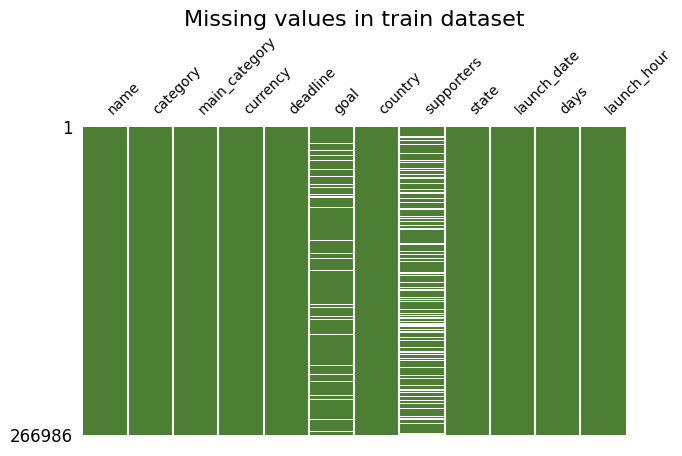

In [17]:
msno.matrix(kick_set, figsize=(7,4), color = (0.3, 0.5, 0.2), fontsize = 10, sparkline = False)
plt.title('Missing values in train dataset', fontdict = {'fontsize':16})
plt.show(); 

### 'name' column
The founder of the fundraiser might not have given the title by mistake, so replace the missing values ​​with '0'

In [18]:
kick_set['name']=kick_set['name'].fillna('0')

### 'goal' column

Perhaps there was no fundraising goal and whatever amount raised was satisfactory, fill in with 0.

In [19]:
kick_set['goal'] = kick_set['goal'].fillna(0)

### 'launch_hour' column

In [20]:
kick_set.dropna(subset=['launch_hour'], inplace=True)

## Extracting data from the 'name' column

### Create 'title_length' column

In [22]:
kick_set['title_lenght'] = kick_set['name'].str.len() 

### Word frequency in 'name' column

In [23]:
kick_freq = kick_set.copy()

kick_freq["title_lower"] = kick_freq['name'].str.lower().str.replace('[^\w\s]','')
words_freq = kick_freq.title_lower.str.split(expand=True).stack().value_counts().reset_index()
 
words_freq.columns = ['Word', 'Frequency'] 
 
words_freq.head(10)

<ipython-input-23-95cda7ce5bdc>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  kick_freq["title_lower"] = kick_freq['name'].str.lower().str.replace('[^\w\s]','')


,Word,Frequency
0,the,74750
1,a,36612
2,of,26701
3,and,18096
4,for,16873
5,to,14750
6,in,12750
7,album,10129
8,new,9932
9,film,8463


In [24]:
kick_new = kick_freq[kick_freq['title_lower'].str.contains('new')]
kick_new.head()

,name,category,main_category,currency,deadline,goal,country,supporters,state,launch_date,days,launch_hour,title_lenght,title_lower
ID,,,,,,,,,,,,,,
276808753,The Dwarves - A New Storydriven Fantasy RPG,Video Games,Games,USD,2015-10-08,260000.0,US,NaN,successful,2015-09-01,37.0,6-12,43,the dwarves a new storydriven fantasy rpg
270411657,LONDON BLUSION - Album - Genre : New Blues,Blues,Music,GBP,2017-04-14,3000.0,GB,1426.0,successful,2017-03-15,30.0,12-18,42,london blusion album genre new blues
2095335534,Newsprint Mural 4 Berlin Café (Painting + Travel),Painting,Art,USD,2013-11-01,1200.0,US,NaN,successful,2013-10-16,16.0,6-12,49,newsprint mural 4 berlin café painting travel
1510757601,"Combine 2 Demos to make new Record ""The Year I...",Indie Rock,Music,USD,2013-12-24,3300.0,US,189.0,failed,2013-12-02,22.0,6-12,58,combine 2 demos to make new record the year i ...
955336537,Graham Show New Single Release in High Definit...,Rock,Music,CAD,2014-04-22,3000.0,CA,1736.0,failed,2014-03-25,28.0,0-6,55,graham show new single release in high definit...


## Groupby

In [29]:
#copy

kick_group=kick_set.copy()

In [30]:
kick_group.groupby(['country','currency']).size().reset_index(name='count')

,country,currency,count
0,AT,EUR,384
1,AU,AUD,5367
2,BE,EUR,430
3,CA,CAD,10034
4,CH,CHF,538
5,DE,EUR,2745
6,DK,DKK,753
7,ES,EUR,1520
8,FR,EUR,2038
9,GB,GBP,23702


In [31]:
print(len(kick_group[kick_group['country']=='N,0"']))

170


Conclusions:

In each country, the fundraising took place in only one currency. There are fundraisers that do not have a country assigned (value 'N,0') and have different currencies. 

For fundraisers from an unspecified country, the country will be assigned based on the currency of the money. The EUR currency appears in different countries, so the country assignment will be random from a group of countries that use the EUR currency.


Because there are more countries than currencies, and both columns are interdependent (in a given country, money is collected in a given currency)
then I will take only the 'country' column for the model.

In [32]:
kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'CAD'),
                           'CA',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'DKK'),
                           'DK',  kick_group['country'])


kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'NOK'),
                           'NO',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'AUD'),
                           'AU',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'GBP'),
                           'GB',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'USD'),
                           'US',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'EUR'),
                           random.choice(['AT', 'BE', 'DE', 'ES', 'FR', 'IE', 'IT', 'LU', 'NL']),  
                           kick_group['country'])


kick_group.groupby(['country', 'currency']).size().reset_index(name='count')

,country,currency,count
0,AT,EUR,384
1,AU,AUD,5373
2,BE,EUR,430
3,CA,CAD,10037
4,CH,CHF,538
5,DE,EUR,2745
6,DK,DKK,756
7,ES,EUR,1520
8,FR,EUR,2038
9,GB,GBP,23720


## Oversampling

In [33]:
kick_over=kick_group.copy()

#oversampling

df_majority = kick_over[kick_over['country'] == 'US']
df_minority = kick_over[(kick_over['country'] != 'US')]

print('=! US ',(df_minority['country'].value_counts().sum()))
print(df_majority['country'].value_counts())

=! US  56724
US    210256
Name: country, dtype: int64


In [34]:
df_minority_upsamlped = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)
df_upsampled = pd.concat([df_majority, df_minority_upsamlped])
df_upsampled.head(3)

,name,category,main_category,currency,deadline,goal,country,supporters,state,launch_date,days,launch_hour,title_lenght
ID,,,,,,,,,,,,,
1397944046,Let Me Introduce Myself; Dani Joy's Debut Ukul...,Jazz,Music,USD,2014-06-10,6000.0,US,NaN,successful,2014-05-11,30.0,0-6,55
276808753,The Dwarves - A New Storydriven Fantasy RPG,Video Games,Games,USD,2015-10-08,260000.0,US,NaN,successful,2015-09-01,37.0,6-12,43
1487389447,Pared Down Productions,Musical,Theater,USD,2015-08-26,4000.0,US,1910.0,successful,2015-06-27,60.0,0-6,22


In [35]:
df_upsampled.drop(['name', 'category', 'deadline', 'currency', 'launch_date', 'supporters'], axis='columns', inplace = True)

In [36]:
# saving only for model and app

# df_upsampled.to_csv('dataset_kickstarter_clean.csv', index=False)

# Data visualization

## Word Cloud
Representation of the frequency of words in a text in 'name' column where the size of the word represents its frequency.
Only for successful fundraisers.

In [51]:
# variable in which all collection names are stored
kick_succes = kick_freq[kick_freq['state'].str.contains('successful')]
text = " ".join(text for text in kick_succes.name)

In [52]:
# STOPWORDS
stopwords = set(STOPWORDS)

#shape
mask = np.array(Image.open('kick_st.png'))

In [57]:
wordcloud = WordCloud(stopwords=stopwords, 
                      mask=mask, 
                      random_state=1, 
                      max_words=300, 
                      background_color='white', 
                      colormap='Dark2', 
                      collocations=False).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Count plot

In [59]:
kick_plot=df_upsampled.copy()

In [61]:
kick_plot

,main_category,goal,country,state,days,launch_hour,title_lenght
ID,,,,,,,
1397944046,Music,6000.0,US,successful,30.0,0-6,55
276808753,Games,260000.0,US,successful,37.0,6-12,43
1487389447,Theater,4000.0,US,successful,60.0,0-6,22
470354679,Art,5000.0,US,failed,30.0,6-12,35
704453339,Crafts,500.0,US,successful,30.0,12-18,39
...,...,...,...,...,...,...,...
908196269,Film & Video,1000.0,CA,failed,30.0,12-18,23
1142622875,Fashion,0.0,CA,failed,30.0,0-6,26
24806604,Games,15000.0,CA,failed,32.0,18-22,15


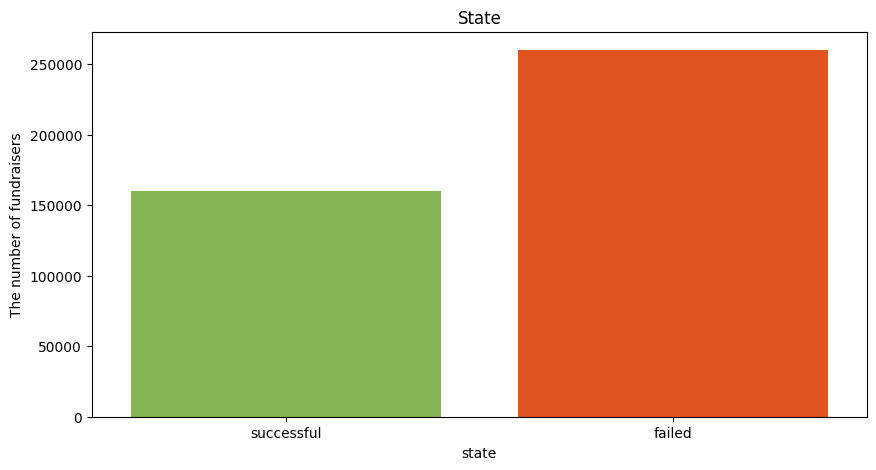

In [62]:
# Graph how many fundraisers were successful and failed

plt.figure(figsize = (10,5))
sns.countplot(x = kick_plot['state'], palette = ['#87C543', 'orangered'])
plt.title('State')
plt.ylabel('The number of fundraisers')
plt.show()

## Bar plot before and after oversampling

In [63]:
# before oversampling

kick_bar = kick_set.copy()

# division into US and other countries
kick_bar['country'] = np.where((kick_bar['country'] == 'US'), 'US', 'other')

#groupby
kick_bar= kick_bar.groupby(['country' , 'state'])[['state']].count()

kick_bar.rename({'state' : 'count'}, axis = 1, inplace=True)
kick_bar.reset_index(inplace = True)

# pivot-table
kick_bar = pd.pivot_table(kick_bar, values='count', index=['country'], columns=['state'])

# set column order
kick_bar = kick_bar.reindex(['failed','successful'], axis=1)
kick_bar

state,failed,successful
country,,
US,122764,87368
other,37119,19729


In [64]:
# after oversampling

kick_bar2 = df_upsampled.copy()

# division into US and other countries
kick_bar2['country'] = np.where((kick_bar2['country'] == 'US'), 'US', 'other')

#groupby
kick_bar2= kick_bar2.groupby(['country' , 'state'])[['state']].count()

kick_bar2.rename({'state' : 'count'}, axis = 1, inplace=True)
kick_bar2.reset_index(inplace = True)

# pivot-table
kick_bar2 = pd.pivot_table(kick_bar2, values='count', index=['country'], columns=['state'])

# set column order
kick_bar2 = kick_bar2.reindex(['failed','successful'], axis=1)
kick_bar2

state,failed,successful
country,,
US,122825,87431
other,137292,72964


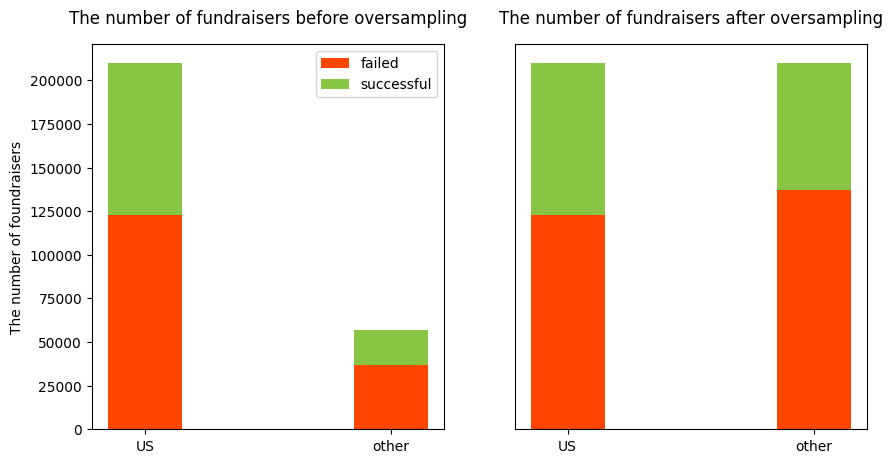

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

ax[0].bar(kick_bar.index, kick_bar['failed'], label = 'failed', color = 'orangered', width = 0.3)

ax[0].bar(kick_bar.index, kick_bar['successful'],
       bottom = kick_bar['failed'],
       label = 'successful', color='#87C543', width = 0.3)

ax[0].set_ylabel('The number of foundraisers')
ax[0].legend(loc = 'upper right')
ax[0].set_title('The number of fundraisers before oversampling', pad = 15)

#after oversampling

ax[1].bar(kick_bar2.index, kick_bar2['failed'], label = 'failed', color = 'orangered', width = 0.3)

ax[1].bar(kick_bar2.index, kick_bar2['successful'],
       bottom =kick_bar2['failed'],
       label = 'successful', color='#87C543', width = 0.3)

ax[1].set_yticks([])
ax[1].set_title('The number of fundraisers after oversampling', pad = 15)

plt.show()

Conclusion: 

Before oversampling, the dataset was not well balanced. In the US, the number of fundraisers was 3.5 times higher than in all other countries combined. After oversampling, the dataset well balanced.

# Models

In [66]:
df_pipeline = df_upsampled.copy()

In [ ]:
models = [ 
    ExtraTreeClassifier(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    CatBoostClassifier(),
    LGBMClassifier(verbose=-1)
    ]

for model in models:
    metrics = model_pipeline(dataset=df_upsampled, model=model)
    print(f'Model: {model.__class__.__name__}')
    display(metrics)
    print()

Model: ExtraTreeClassifier


,Metric,Value_train,Value_val,Value_test
0,Accuracy,0.97,0.77,0.77
1,Precision,0.97,0.77,0.77
2,Recall,0.97,0.77,0.77
3,F1 Score,0.97,0.77,0.77
4,Total,269127.00,67282.00,84103.00
5,Mislabeled,7786.00,15374.00,19198.00



Model: RandomForestClassifier


,Metric,Value_train,Value_val,Value_test
0,Accuracy,0.97,0.79,0.79
1,Precision,0.97,0.79,0.79
2,Recall,0.97,0.79,0.79
3,F1 Score,0.97,0.79,0.79
4,Total,269127.00,67282.00,84103.00
5,Mislabeled,7816.00,14216.00,17807.00



Learning rate set to 0.112338
0:	learn: 0.6770924	total: 95.9ms	remaining: 1m 35s
1:	learn: 0.6649562	total: 129ms	remaining: 1m 4s
2:	learn: 0.6555061	total: 163ms	remaining: 54s
3:	learn: 0.6475248	total: 195ms	remaining: 48.5s
4:	learn: 0.6408712	total: 224ms	remaining: 44.5s
5:	learn: 0.6354602	total: 265ms	remaining: 43.9s
6:	learn: 0.6311338	total: 296ms	remaining: 42s
7:	learn: 0.6274304	total: 329ms	remaining: 40.8s
8:	learn: 0.6242905	total: 363ms	remaining: 39.9s
9:	learn: 0.6212218	total: 393ms	remaining: 38.9s
10:	learn: 0.6186064	total: 428ms	remaining: 38.5s
11:	learn: 0.6161437	total: 460ms	remaining: 37.9s
12:	learn: 0.6141262	total: 491ms	remaining: 37.3s
13:	learn: 0.6122426	total: 519ms	remaining: 36.6s
14:	learn: 0.6107488	total: 563ms	remaining: 36.9s
15:	learn: 0.6092557	total: 595ms	remaining: 36.6s
16:	learn: 0.6076707	total: 627ms	remaining: 36.2s
17:	learn: 0.6063735	total: 658ms	remaining: 35.9s
18:	learn: 0.6052831	total: 690ms	remaining: 35.6s
19:	learn: 0

,Metric,Value_train,Value_val,Value_test
0,Accuracy,0.72,0.71,0.71
1,Precision,0.71,0.70,0.70
2,Recall,0.72,0.71,0.71
3,F1 Score,0.71,0.70,0.70
4,Total,269127.00,67282.00,84103.00
5,Mislabeled,75209.00,19778.00,24573.00



Model: LGBMClassifier


,Metric,Value_train,Value_val,Value_test
0,Accuracy,0.69,0.69,0.69
1,Precision,0.69,0.68,0.68
2,Recall,0.69,0.69,0.69
3,F1 Score,0.68,0.68,0.68
4,Total,269127.00,67282.00,84103.00
5,Mislabeled,82310.00,20921.00,26049.00


## Optuna

In [ ]:
def objective(trial):
    # Define X and y
    X = df_pipeline[['main_category', 'goal', 'country', 'days', 'launch_hour', 'title_lenght']]
    y = df_pipeline['state']

    # Split data into train, test, validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # select categorical cols
    categorical_cols = ['main_category', 'country', 'launch_hour']

    # select cols
    numerical_cols = ['goal', 'days', 'title_lenght']
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = MinMaxScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numerical_transformer, numerical_cols)])

    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42
    }

    # Define the model with the selected hyperparameters
    model = RandomForestClassifier(**params)

    # Create the pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Fit the pipeline on the training data
    my_pipeline.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = my_pipeline.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, preds_val)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


In [ ]:
# Print the best parameters and best accuracy
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'iterations': 188, 'learning_rate': 0.09986088211874038, 'l2_leaf_reg': 0.0014083323077725804, 'bootstrap_type': 'MVS'}
Best accuracy: 0.6881038019083856


# Conclusions
Model Random forest was selected for the web app. All calculated metrics for model Random Forest are higher, which means that this model performs better.